Abstract

Neural networking is a form of machine learning inspired by the biological function of the human brain. By giving the program known inputs and outputs of a function, the computer learns the outputs of the function. In this program, the computer is given a set of 1792 hand written digits from zero to nine. Each 64 pixel digit is given as a 2D array of values correspoding to the pixel shade; similar images will have similar arrays. After a training period is completed, the computer will be able to output the value for any of the 1792 hand written digits with an accuracy significantly greater than guessing. This neural network is contructed with 64 inputs in a single input layer, a variable number of hidden nuerons in a single hidden layer, and 10 outputs in a single output layer. The training set is also variable. 

After the computer is put through a training session involving only a portion of the 1792 images, it will be given the entire set of images. The computer's outputs will be compared to the true values and a percent error will verify the code is working. 

Once the program is working, and the computer can accurately determine the image array values, the program is then modified to allow for multiple hidden layers and again trained and tested with the 1792 digit set. Then, it will be programmed to translate morse using non-handwritten dashes and periods. From this, the training set will be the entire morse dictionary and the "test" set will be human entered morse code sentences. Because there will be no variation in the test set and the training set, this is more of a question of how many iterations does it take to learn identical data. Also, this will be a neural network with 4 nodes in the input layer and 26 nodes in the output layer. It will interesting to see how long many interations it will take to get 100% and the time it takes to get it. 

In [57]:
import numpy as np
from sklearn.datasets import load_digits 
digits = load_digits()
from IPython.html.widgets import interact
%matplotlib inline
import matplotlib.pyplot as plt
import timeit
from IPython.display import Image
import NNpix as npx
import timeit

A neuron in the brain can either fire or not fire. Computer based neural networks attempt to imitate the operations of a brain.  This is done with an activation function. An ideal activation function would be a step function. At some threshold value, the neuron "fires" and produced a value of 1. If this threshold is not met, it produces 0. However, computationally, it is mathmatically convienient to have a smooth function. Thus, the sigmoid function is used. Since this activation function will be used extensively in the devepment of a neural network, the first step is defining a function that calculates the sigmoid of a value. 

$$\sigma(x) = \frac {1}{1+e^{-x}}$$

In [2]:
""" The activation function. """
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [5]:
assert sigmoid(np.log(2)) == 2/3

In [8]:
""" The """
def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x))

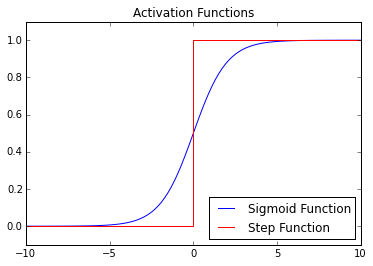

In [5]:
x = np.linspace(-10,10,100)
y = sigmoid(x)
a = [-10,-1,0,1,10]
b = [0,0,0,1,1]
plt.plot(x,y, label="Sigmoid Function")
plt.step(a,b, "r", label="Step Function")
plt.xlim(-10,10)
plt.ylim(-0.1,1.1)
plt.title("Activation Functions")
plt.legend(loc=4)
plt.show()

In [27]:
""" Using random permutations to train with random values of the total set """
perm = np.random.permutation(1797)

In [28]:
assert len(perm) == 1797

In [30]:
"""Turn each 2D array into 1D array, turn all integers into decimals, append 1 for the input bias"""

# training_input = np.array([np.append((digits.images[perm[i]].flatten())/100,[1]) for i in range(1000)])
training_input = np.array([digits.images[perm[i]].flatten() for i in range(1000)])/100
test_input = np.array([digits.images[perm[i]].flatten() for i in range(1000,1797)])/100

In [31]:
assert len(training_input[0]) == 64

In [33]:
assert len(test_input[0]) == 64

Creating the solutions to the training input is a bit more involved. The simplest way to approach this is with 10 output neurons in a single output layer. Each of these neurons will represent a different number from 0-9 based on their index. Here, a function is created that takes a set of single digit numbers and creates a 2D array that represent those numbers. This is the solution array to the training inputs. 

In [34]:
def create_training_soln(training_numbers):
    """ Creates 2D array for training solutions """
    a = np.repeat(0,10,None)
    a = np.repeat([a], len(training_numbers), 0)
    for i in range(len(training_numbers)):
        a[i][training_numbers[i]] = 1
    return a

In [44]:
"""Generat a training solution"""
training_solution = create_training_soln([digits.target[perm[i]] for i in range(1000)])
test_solution = create_training_soln([digits.target[perm[i]] for i in range(1000,1797)])
number_solution = np.array([digits.target[perm[i]] for i in range(1000,1797)])

In [45]:
assert len(training_solution[0]) == 10
assert len(test_solution[0]) == 10

This is the bulk of the program. Here is where the training and backpropogation takes place to generate weights that best fit the data. I, J, and K each represent a layer. "I" is the input layer, "J" is the hidden layer, and "K" is the output layer. "WIJ" is then the array of weights between the I and J layers and "WJK" being the same between the J and K layers. These arrays are initially randomized, and change with iterations depending on the output error. 

The easiest way to process what exactly is going on below is to think of it very simplistically and mathematically. The computer is given an input. The input is multiplied by weights, summed and fed into a sigmoid function. This process occurs for each of the hidden neurons, each using the same input, but different weights. Since only a single number is fed into the sigmoid function of each neuron, only a single number is outputed by each hidden neuron. These hidden neuron outputs are then treated as inputs for the output layer. The hidden layer outputs are multiplied by weights, summed and fed into a sigmoid function. The outputs of this sigmoid function, are the outputs of the output layer, thus the final output. The difference between the expected output and the actual output is computed, and this difference is used to changed the weights. Once the weights have been changed, the process is repeated with a new image. 

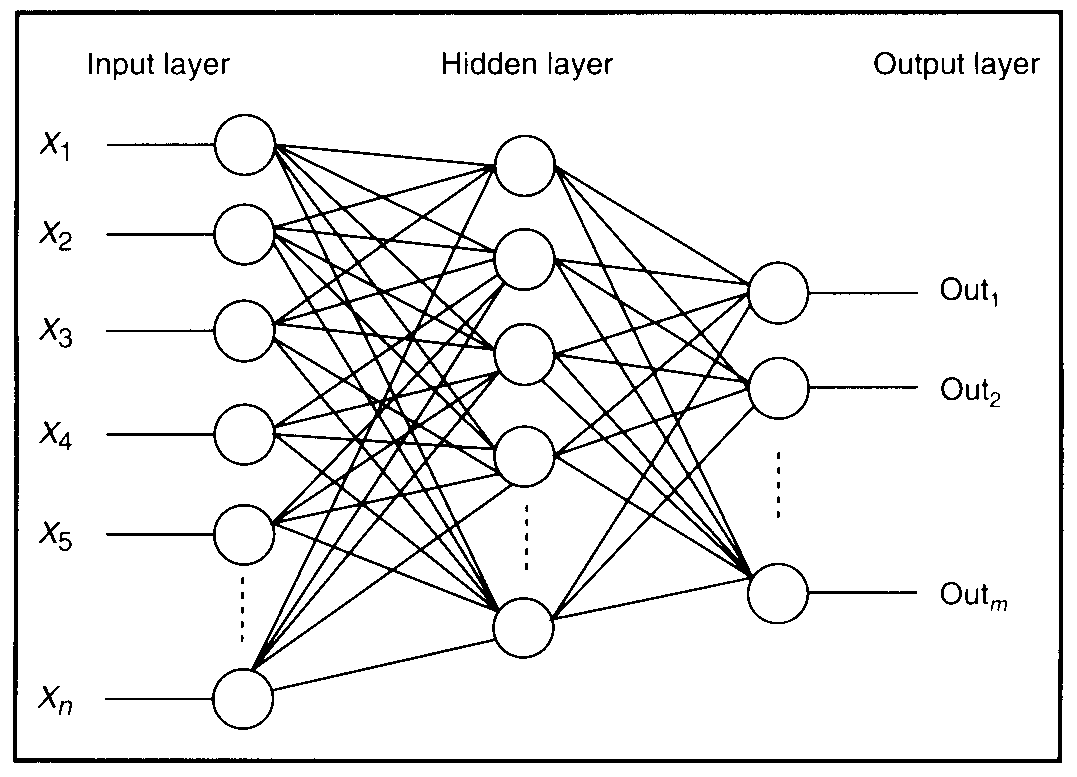

In [46]:
Image(url='http://mechanicalforex.com/wp-content/uploads/2011/06/NN.png', embed=True, width = 400, height = 400)

This diagram is "messy" simply because that is the nature of neutral networks! It has an organization, but everything connects to the layer before it. This diagram also depicts multiple output neurons which is essential to this neural network. 

To explain mathmatically what is going on, let's do some calculations:

Here is the cost function:

$$C = \frac{1}{2}(y-\hat{y})^{2} $$

Note that $ \hat{y} $ is the computer solution array  and $ y $ is the solution value array.

We do not know $ \frac{\partial{\hat{y}}}{\partial{W_2}} $ but we can break it into partials that we do know. 

$$ \frac{\partial{C}}{\partial{W_2}} = -(y-\hat{y})^{2} \frac{\partial{\hat{y}}}{\partial{c}} \frac{\partial{c}}{\partial{W_2}} $$

And we know $\hat{y} = \sigma(c) $ where $c$ is the array of outputs. 

In [47]:
class NN_training(object):
    
    def __init__(self, input_array, soln, hidnum, iters, lr):
        self.input_array = input_array
        self.soln = soln
        #Number of hidden nodes
        self.hidnum = hidnum
        #Number of iterations through the training set
        self.iters = iters
        #Initalize WIJ weights (input to hidden)
        self.wij = np.random.uniform(-.5,0.5,(hidnum,65))
        #Initalize WJK weights (hidden to output)
        self.wjk = np.random.uniform(-0.5,0.5,(10,hidnum+1))
        #Set a learning rate
        self.lr = lr


    def train(self):
        iters = self.iters   
        for n in range(iters): 
            for i in range(len(self.input_array)):
                soln = self.soln[i]
                hidnum = self.hidnum
                input_array = np.append(self.input_array[i],[1])
                #Find sum of weights x input array values for each hidden
                self.hidden_sums = (sum((input_array * self.wij).T)).T
                #Find outputs of hidden neurons; include bias
                self.hidden_out = np.append(sigmoid(self.hidden_sums),[1])
                #Find sums of weights x hidden outs for each neuron in output layer
                self.output_sums = (sum((self.hidden_out * self.wjk).T)).T
                #Find output of the outputs
                self.output_out = sigmoid(self.output_sums)
                self.E = self.output_out - soln
                 #Find delta values for each output
                self.output_deltas = self.E * sigmoid_prime(self.output_sums)
                 #Find delta values for each hidden
                self.hidden_deltas = sigmoid_prime(np.delete(self.hidden_out,[hidnum],None)) * sum((self.output_deltas * (np.delete(self.wjk, [hidnum], 1)).T).T)
                #Change weights
                self.wij = -self.lr * (self.hidden_deltas*(np.repeat([input_array],hidnum,0)).T).T + self.wij
                self.wjk = -self.lr * (self.output_deltas*(np.repeat([self.hidden_out],10,0)).T).T + self.wjk
        return (self.wij, self.wjk)


Now that the neural network has been constructed, it is time to train it. First, create an instance of a class with 30 hidden nuerons, 60 iterations, and a learning rate of 0.7.

In [48]:
""" Create an instance of a class """
my_net = NN_training(training_input, training_solution, 40, 90, 0.7)

Let x be the final WIJ and y be the final WJK.

In [49]:
""" Get final weights """
x,y = my_net.train()

Saving the weights for the class demonstration. 

In [63]:
np.savez("NNweights.npz", x,y)

Although there is a bulk of code below, it is almost entirely identical to the training class above. The essential difference being the weights are fed into the NN_ask class, no iterations are taking place, no weights are being changed, and no solutions are fed into the program. The purpose here is to give the program inputs and see if it has "learned". This is the test for the learning code above. With the calculated weights, this program should be able to calculate an output for all 1797 hand written digits that matches the solutions with minimal error. 

In [51]:
class NN_ask (object):
    """ Feed forward using final weights from training backpropagation """
    def __init__(self, input_array, wij, wjk):
        self.input_array = input_array
        self.wij = wij
        self.wjk = wjk
    def get_ans(self):
        wij = self.wij
        wjk = self.wjk
        soln = []
        for i in range(len(self.input_array)):
            input_array = np.append(self.input_array[i],[1])
            self.hidden_sums = (sum((input_array * wij).T)).T
            self.hidden_out = np.append(sigmoid(self.hidden_sums),[1]) 
            self.output_sums = (sum((self.hidden_out * wjk).T)).T
            self.output_out = sigmoid(self.output_sums)
            for i in range(len(self.output_out)):
                if self.output_out[i] == max(self.output_out):
                    a = i
                    soln.append(a)
        return soln

In [52]:
""" Instance of NN_ask class using calculated weights and all 1797 images"""
test_net = NN_ask(test_input, x, y)

"comp_vals" is set equal to the computer's output for all the 1797 images

In [53]:
""" Get the computer's output for all 1797 images """
comp_vals = test_net.get_ans() 

And finally, the error is calculated between the computer's answers and the actual answers for all the digits. 

In [54]:
""" Calculate error """
print(((sum((comp_vals-number_solution == 0).astype(int)) / (1797-1000)) * 100), "%")

96.2358845671 %
